In [ ]:
import numpy as np

def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

def tanh(x):
    x = np.clip(x, -500, 500)
    return np.tanh(x)

def sigmoid_derivative(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

def tanh_derivative(x):
    return 1 - tanh(x)**2

class GRUCell:
    def __init__(self, input_dim, hidden_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Xavier/Glorot initialization
        limit = np.sqrt(6 / (input_dim + hidden_dim))
        self.Wz = np.random.uniform(-limit, limit, (hidden_dim, input_dim))
        self.Uz = np.random.uniform(-limit, limit, (hidden_dim, hidden_dim))
        self.bz = np.zeros((hidden_dim, 1))

        self.Wr = np.random.uniform(-limit, limit, (hidden_dim, input_dim))
        self.Ur = np.random.uniform(-limit, limit, (hidden_dim, hidden_dim))
        self.br = np.zeros((hidden_dim, 1))

        self.Wh = np.random.uniform(-limit, limit, (hidden_dim, input_dim))
        self.Uh = np.random.uniform(-limit, limit, (hidden_dim, hidden_dim))
        self.bh = np.zeros((hidden_dim, 1))

        # Adam optimizer parameters
        self.m = {param: np.zeros_like(getattr(self, param)) for param in ['Wz', 'Uz', 'bz', 'Wr', 'Ur', 'br', 'Wh', 'Uh', 'bh']}
        self.v = {param: np.zeros_like(getattr(self, param)) for param in ['Wz', 'Uz', 'bz', 'Wr', 'Ur', 'br', 'Wh', 'Uh', 'bh']}
        self.t = 0

        self.reset_gradients()

    def reset_gradients(self):
        self.dWz = np.zeros_like(self.Wz)
        self.dUz = np.zeros_like(self.Uz)
        self.dbz = np.zeros_like(self.bz)
        self.dWr = np.zeros_like(self.Wr)
        self.dUr = np.zeros_like(self.Ur)
        self.dbr = np.zeros_like(self.br)
        self.dWh = np.zeros_like(self.Wh)
        self.dUh = np.zeros_like(self.Uh)
        self.dbh = np.zeros_like(self.bh)
        self.dbh = np.zeros_like(self.bh)

    def forward(self, x, h_prev):
       
        # Ensure x is 2D
        if x.ndim == 1:
            x = x.reshape(-1, 1)

        # Gerbang update
        self.z = sigmoid(np.dot(self.Wz, x) + np.dot(self.Uz, h_prev) + self.bz)

        # Gerbang reset
        self.r = sigmoid(np.dot(self.Wr, x) + np.dot(self.Ur, h_prev) + self.br)

        # Kandidat state tersembunyi
        self.h_tilde = tanh(np.dot(self.Wh, x) + np.dot(self.Uh, (self.r * h_prev)) + self.bh)

        # State tersembunyi akhir
        h = (1 - self.z) * h_prev + self.z * self.h_tilde

        self.x, self.h_prev, self.h = x, h_prev, h
        return h

    def backward(self, dh_next):
        
        dz = dh_next * (self.h_tilde - self.h_prev) * sigmoid_derivative(self.z)
        dh_tilde = dh_next * self.z * tanh_derivative(self.h_tilde)
        dr = dh_tilde * np.dot(self.Uh.T, self.h_prev) * sigmoid_derivative(self.r)

        self.dWz += np.dot(dz, self.x.T)
        self.dUz += np.dot(dz, self.h_prev.T)
        self.dbz += np.sum(dz, axis=1, keepdims=True)

        self.dWr += np.dot(dr, self.x.T)
        self.dUr += np.dot(dr, self.h_prev.T)
        self.dbr += np.sum(dr, axis=1, keepdims=True)

        self.dWh += np.dot(dh_tilde, self.x.T)
        self.dUh += np.dot(dh_tilde, (self.r * self.h_prev).T)
        self.dbh += np.sum(dh_tilde, axis=1, keepdims=True)

        dh_prev = (1 - self.z) * dh_next + np.dot(self.Uz.T, dz) + np.dot(self.Ur.T, dr) + np.dot(self.Uh.T, (dh_tilde * self.r))
        return dh_prev

    def update_weights(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
       
        self.t += 1

        for param in ['Wz', 'Uz', 'bz', 'Wr', 'Ur', 'br', 'Wh', 'Uh', 'bh']:
            grad = getattr(self, 'd' + param)

            # Gradient clipping
            np.clip(grad, -1.0, 1.0, out=grad)

            # Adam update
            self.m[param] = beta1 * self.m[param] + (1 - beta1) * grad
            self.v[param] = beta2 * self.v[param] + (1 - beta2) * (grad ** 2)

            m_hat = self.m[param] / (1 - beta1 ** self.t)
            v_hat = self.v[param] / (1 - beta2 ** self.t)

            update = learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

            setattr(self, param, getattr(self, param) - update)

        self.reset_gradients()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

def load_and_prepare_data(file_path, column_name, seq_length, test_size=0.2, val_size=0.2):
   
    try:
        # Load data from Excel file
        data = pd.read_excel(file_path)

        # Extract specified column
        if column_name not in data.columns:
            raise ValueError(f"Column '{column_name}' not found in the Excel file.")

        raw_data = data[column_name].values

        # Normalize the data
        scaler = MinMaxScaler(feature_range=(0, 1))
        normalized_data = scaler.fit_transform(raw_data.reshape(-1, 1))

        # Prepare sequences
        X, y = [], []
        for i in range(len(normalized_data) - seq_length):
            X.append(normalized_data[i:i+seq_length])
            y.append(normalized_data[i+seq_length])

        X, y = np.array(X), np.array(y)

        # Reshape X to be [samples, time steps, features]
        X = X.reshape(X.shape[0], X.shape[1], 1)

        # First, split into training+validation and test sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

        # Then split the training set into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, random_state=42)

        print(f"Training data shape: {X_train.shape}")
        print(f"Validation data shape: {X_val.shape}")
        print(f"Testing data shape: {X_test.shape}")

        return X_train, X_val, X_test, y_train, y_val, y_test, scaler

    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

def train_gru(X_train, y_train, X_val, y_val, input_dim, hidden_dim, epochs=50, learning_rate=0.001, batch_size=32):
    gru = GRUCell(input_dim, hidden_dim)
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        total_train_loss = 0
        total_val_loss = 0

        # Training
        for i in tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}/{epochs} (Training)"):
            batch_X = X_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]

            batch_loss = 0
            for j in range(len(batch_X)):
                x_seq = batch_X[j]
                y_true = batch_y[j]

                # Forward pass
                h = np.zeros((hidden_dim, 1))
                for t in range(x_seq.shape[0]):
                    x_t = x_seq[t].reshape(-1, 1)
                    h = gru.forward(x_t, h)

                # Calculate loss (mean squared error)
                y_pred = h[-1][0]
                loss = (y_true - y_pred)**2
                batch_loss += loss

                # Backward pass
                dh_next = 2 * (y_pred - y_true)
                for t in reversed(range(x_seq.shape[0])):
                    x_t = x_seq[t].reshape(-1, 1)
                    dh_next = gru.backward(dh_next)

            # Update weights
            gru.update_weights(learning_rate)
            total_train_loss += batch_loss

        # Validation
        for i in range(len(X_val)):
            x_seq = X_val[i]
            y_true = y_val[i]

            # Forward pass
            h = np.zeros((hidden_dim, 1))
            for t in range(x_seq.shape[0]):
                x_t = x_seq[t].reshape(-1, 1)
                h = gru.forward(x_t, h)

            # Calculate loss
            y_pred = h[-1][0]
            loss = (y_true - y_pred)**2
            total_val_loss += loss

        # Record losses
        avg_train_loss = float(np.mean(total_train_loss))
        avg_val_loss = float(np.mean(total_val_loss))
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return gru, history

# Usage
file_path = 'main_data.xlsx'
column_name = 'Terakhir_IDR'
seq_length = 10

X_train, X_val, X_test, y_train, y_val, y_test, scaler = load_and_prepare_data(file_path, column_name, seq_length)

input_dim = X_train.shape[2]
hidden_dim = 100
gru, history = train_gru(X_train, y_train, X_val, y_val, input_dim, hidden_dim)

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import pickle

# Fungsi untuk menyimpan model
def save_model(gru, filename):
    with open(filename, 'wb') as f:
        pickle.dump(gru, f)

# Fungsi untuk memuat model
def load_model(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# Simpan model setelah pelatihan
save_model(gru, 'gru_model.pkl')

# Contoh memuat model
loaded_gru = load_model('gru_model.pkl')


MAE: 3.77
RMSE: 4.93
Hasil prediksi telah disimpan ke prediksi_hasil.xlsx


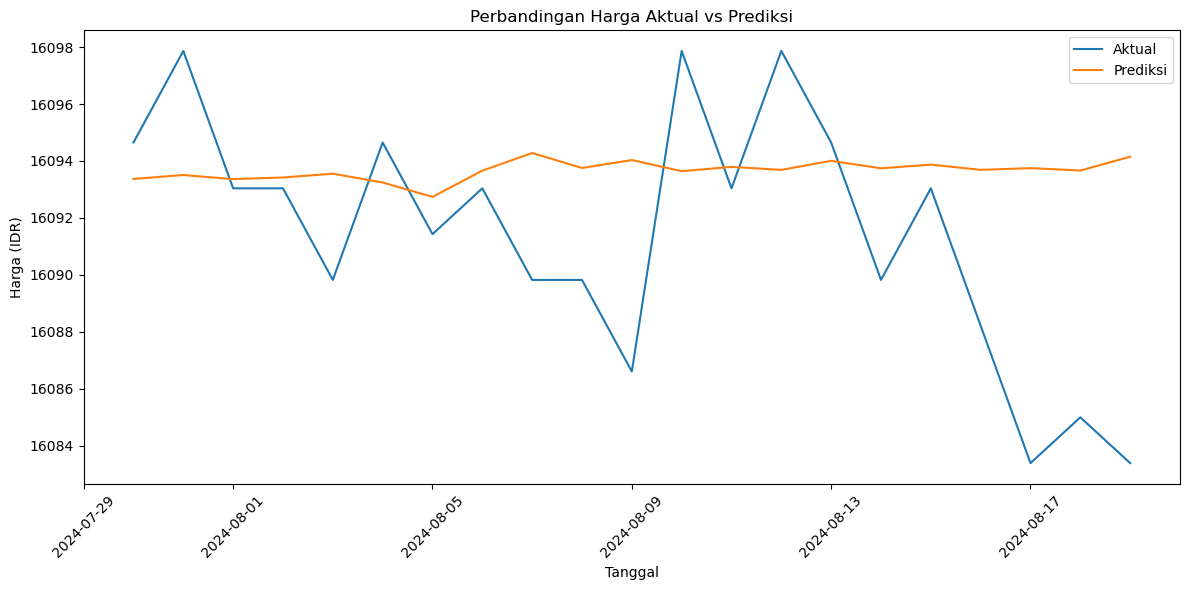

,Tanggal,data_close,prediksi_close,selisih,persentase_selisih
0,2024-07-30,16094.648286,16093.370087,1.278199,0.007942
1,2024-07-31,16097.866572,16093.507031,4.359541,0.027081
2,2024-08-01,16093.039143,16093.362813,-0.323670,-0.002011
3,2024-08-02,16093.039143,16093.420115,-0.380972,-0.002367
4,2024-08-03,16089.820857,16093.553849,-3.732992,-0.023201
5,2024-08-04,16094.648286,16093.244951,1.403335,0.008719
6,2024-08-05,16091.430000,16092.738064,-1.308064,-0.008129
7,2024-08-06,16093.039143,16093.660811,-0.621668,-0.003863
8,2024-08-07,16089.820857,16094.280825,-4.459968,-0.027719
9,2024-08-08,16089.820857,16093.755163,-3.934306,-0.024452


In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pickle

# Load the scaler and model
with open('gru_model.pkl', 'rb') as f:
    loaded_gru = pickle.load(f)

# Define the file paths and parameters
file_path = 'test.xlsx'  # Path to your uploaded test data file
output_file_path = 'prediksi_hasil.xlsx'
seq_length = 10

# Load and prepare the test data
test_data = pd.read_excel(file_path)
test_data_close = test_data['Terakhir_IDR'].values  # Adjust the column name as needed

# Normalisasi data test (gunakan scaler yang sama dengan data training)
scaler = MinMaxScaler(feature_range=(0, 1))
test_data_normalized = scaler.fit_transform(test_data_close.reshape(-1, 1))

# Fungsi prediksi
def make_predictions(model, data, seq_length):
    predictions = []
    for i in range(len(data) - seq_length):
        x_seq = data[i:i + seq_length]
        h = np.zeros((model.hidden_dim, 1))
        for t in range(seq_length):
            x_t = x_seq[t].reshape(-1, 1)
            h = model.forward(x_t, h)
        y_pred = h[-1][0]
        predictions.append(y_pred)
    return np.array(predictions)

# Buat prediksi
predictions = make_predictions(loaded_gru, test_data_normalized, seq_length)

# Denormalisasi hasil prediksi
predictions_denormalized = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

# Buat dataframe hasil prediksi
results = pd.DataFrame({
    'Tanggal': test_data['Tanggal'][seq_length:].values,
    'data_close': test_data_close[seq_length:],
    'prediksi_close': predictions_denormalized,
})

# Hitung selisih dan persentase selisih
results['selisih'] = results['data_close'] - results['prediksi_close']
results['persentase_selisih'] = (results['selisih'] / results['data_close']) * 100

# Hitung MAE dan RMSE
mae = mean_absolute_error(results['data_close'], results['prediksi_close'])
rmse = np.sqrt(mean_squared_error(results['data_close'], results['prediksi_close']))
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Simpan hasil prediksi
results.to_excel(output_file_path, index=False)
print(f"Hasil prediksi telah disimpan ke {output_file_path}")

# Visualisasi
plt.figure(figsize=(12, 6))
plt.plot(results['Tanggal'], results['data_close'], label='Aktual')
plt.plot(results['Tanggal'], results['prediksi_close'], label='Prediksi')
plt.title('Perbandingan Harga Aktual vs Prediksi')
plt.xlabel('Tanggal')
plt.ylabel('Harga (IDR)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

results




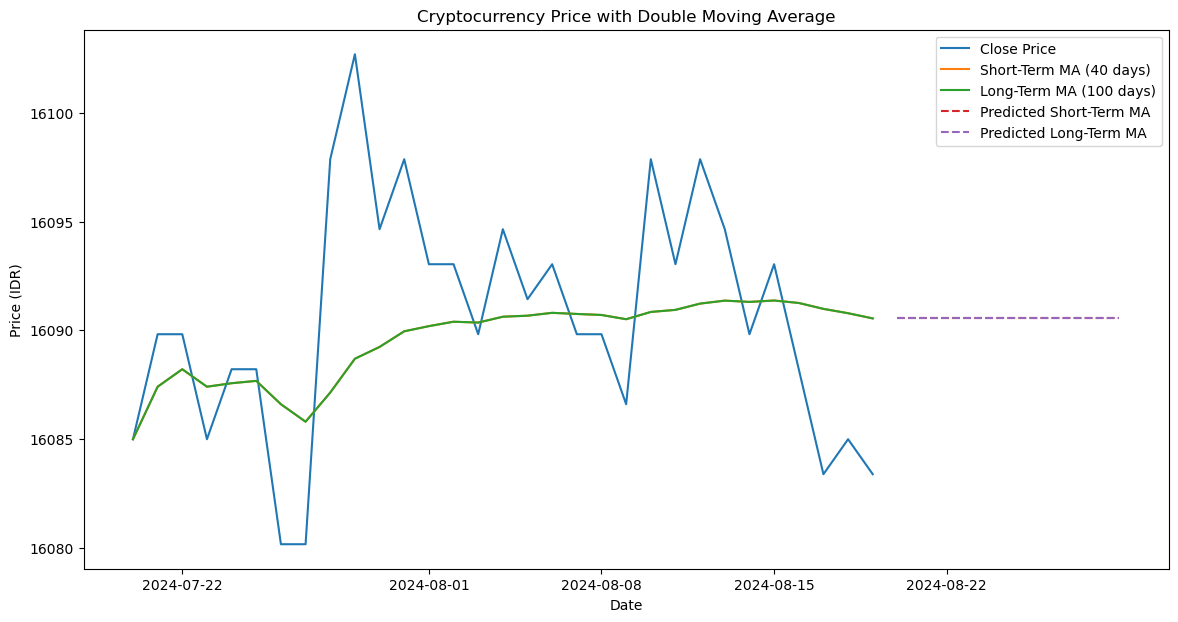

,No,Terakhir_IDR,Pembukaan_IDR,Tertinggi_IDR,Terendah_IDR,Short_MA,Long_MA
Tanggal,,,,,,,
2024-07-20,1,16084.993428,16093.039143,16094.648286,16076.947713,16084.993428,16084.993428
2024-07-21,2,16089.820857,16084.993428,16093.039143,16081.775142,16087.407143,16087.407143
2024-07-22,3,16089.820857,16089.820857,16094.648286,16084.993428,16088.211714,16088.211714
2024-07-23,4,16084.993428,16089.820857,16093.039143,16083.384285,16087.407143,16087.407143
2024-07-24,5,16088.211714,16084.993428,16089.820857,16083.384285,16087.568057,16087.568057
2024-07-25,6,16088.211714,16088.211714,16094.648286,16084.993428,16087.675333,16087.675333
2024-07-26,7,16080.165999,16088.211714,16093.039143,16070.511141,16086.602571,16086.602571
2024-07-27,8,16080.165999,16080.165999,16084.993428,16073.729427,16085.798000,16085.798000
2024-07-28,9,16097.866572,16080.165999,16099.475715,16080.165999,16087.138952,16087.138952


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_data(file_path):
    """Load the cryptocurrency data from an Excel file."""
    data = pd.read_excel(file_path)
    data['Tanggal'] = pd.to_datetime(data['Tanggal'], format='%d/%m/%Y')
    data.set_index('Tanggal', inplace=True)
    return data

def calculate_moving_averages(data, short_window, long_window):
    """Calculate the short-term and long-term moving averages."""
    data['Short_MA'] = data['Terakhir_IDR'].rolling(window=short_window, min_periods=1).mean()
    data['Long_MA'] = data['Terakhir_IDR'].rolling(window=long_window, min_periods=1).mean()
    return data

def predict_dma(data, short_window, long_window, prediction_window):
    """Predict future trends based on DMA."""
    short_ma_future = [data['Short_MA'].iloc[-1]] * prediction_window
    long_ma_future = [data['Long_MA'].iloc[-1]] * prediction_window
    return short_ma_future, long_ma_future

def save_to_excel(data, output_file_path):
    """Save the processed data to an Excel file."""
    data.to_excel(output_file_path, index=True)

def plot_data(data, short_window, long_window, short_ma_future, long_ma_future):
    """Plot the closing prices and moving averages."""
    plt.figure(figsize=(14, 7))
    plt.plot(data['Terakhir_IDR'], label='Close Price')
    plt.plot(data['Short_MA'], label=f'Short-Term MA ({short_window} days)')
    plt.plot(data['Long_MA'], label=f'Long-Term MA ({long_window} days)')

    future_dates = pd.date_range(start=data.index[-1], periods=len(short_ma_future) + 1, freq='D')[1:]
    plt.plot(future_dates, short_ma_future, '--', label='Predicted Short-Term MA')
    plt.plot(future_dates, long_ma_future, '--', label='Predicted Long-Term MA')

    plt.title('Cryptocurrency Price with Double Moving Average')
    plt.xlabel('Date')
    plt.ylabel('Price (IDR)')
    plt.legend()
    plt.show()

# File path to the Excel file
file_path = 'test.xlsx'
output_file_path = 'hasil.xlsx'
short_window = 40
long_window = 100
prediction_window = 10  # Number of days to predict

# Load the data
data = load_data(file_path)

# Calculate the moving averages
data = calculate_moving_averages(data, short_window, long_window)

# Predict future trends
short_ma_future, long_ma_future = predict_dma(data, short_window, long_window, prediction_window)

# Save the processed data to a new Excel file
save_to_excel(data, output_file_path)



# Plot the data
plot_data(data, short_window, long_window, short_ma_future, long_ma_future)

# Display the first few rows with the new columns
data


Hasil prediksi dan perbandingan metrik telah disimpan ke prediksi_hasil.xlsx


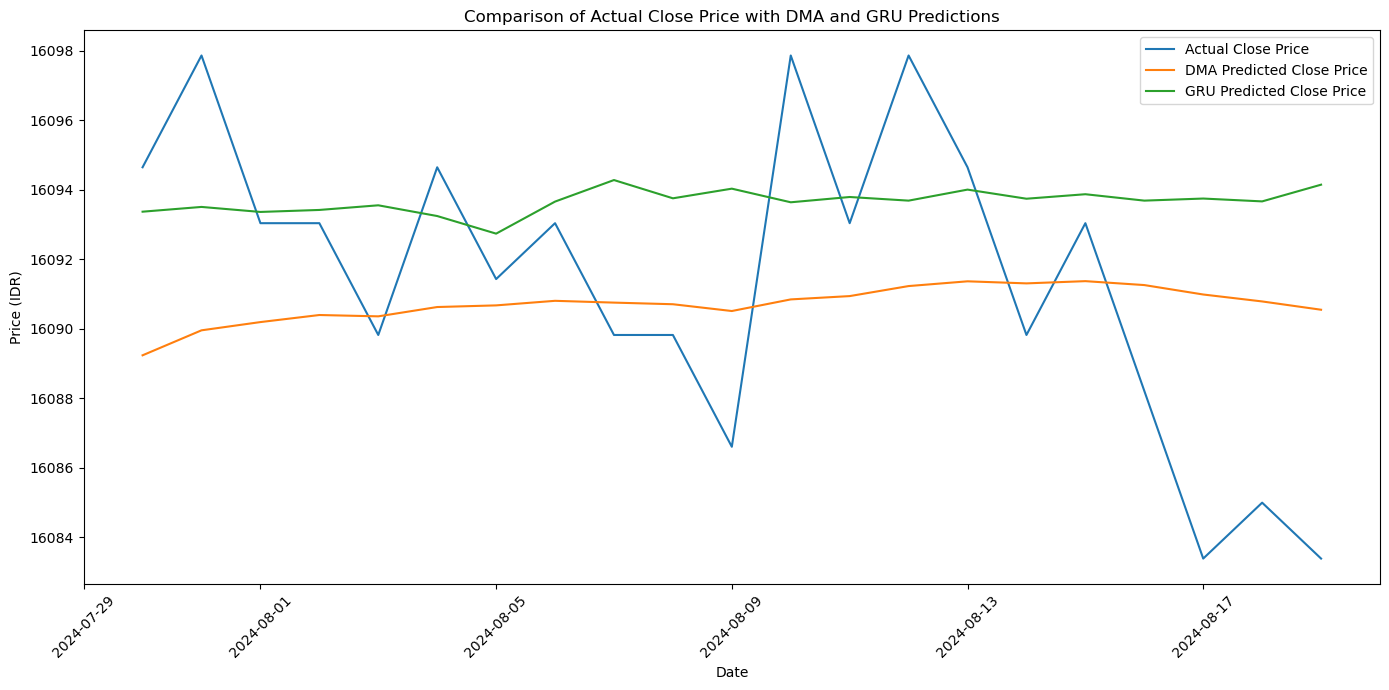

,Metric,DMA,GRU
0,MAE,3.709031,3.765069
1,RMSE,4.426204,4.929610
2,MAPE,0.023050,0.023402
3,MPE,0.004488,-0.013883


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Buat prediksi menggunakan model GRU yang sudah dimuat
gru_predictions = make_predictions(loaded_gru, test_data_normalized, seq_length)
gru_predictions_denormalized = scaler.inverse_transform(gru_predictions.reshape(-1, 1)).flatten()

# Hitung DMA (Double Moving Average)
data = calculate_moving_averages(test_data, short_window, long_window)
predictions_denormalized = data['Short_MA'].iloc[seq_length:].values

# Update dataframe hasil dengan prediksi GRU dan DMA
results = pd.DataFrame({
    'Tanggal': test_data['Tanggal'][seq_length:].values,
    'data_close': test_data_close[seq_length:],
    'prediksi_close_dma': predictions_denormalized,
    'prediksi_close_gru': gru_predictions_denormalized,
})

# Hitung selisih dan persentase selisih
results['selisih_dma'] = results['data_close'] - results['prediksi_close_dma']
results['persentase_selisih_dma'] = (results['selisih_dma'] / results['data_close']) * 100
results['selisih_gru'] = results['data_close'] - results['prediksi_close_gru']
results['persentase_selisih_gru'] = (results['selisih_gru'] / results['data_close']) * 100

# Hitung metrik kinerja
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_percentage_error(y_true, y_pred):
    return np.mean((y_true - y_pred) / y_true) * 100

mae_dma = mean_absolute_error(results['data_close'], results['prediksi_close_dma'])
rmse_dma = np.sqrt(mean_squared_error(results['data_close'], results['prediksi_close_dma']))
mape_dma = mean_absolute_percentage_error(results['data_close'], results['prediksi_close_dma'])
mpe_dma = mean_percentage_error(results['data_close'], results['prediksi_close_dma'])

mae_gru = mean_absolute_error(results['data_close'], results['prediksi_close_gru'])
rmse_gru = np.sqrt(mean_squared_error(results['data_close'], results['prediksi_close_gru']))
mape_gru = mean_absolute_percentage_error(results['data_close'], results['prediksi_close_gru'])
mpe_gru = mean_percentage_error(results['data_close'], results['prediksi_close_gru'])

# Tabel perbandingan metrik kinerja
metrics_comparison = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE', 'MPE'],
    'DMA': [mae_dma, rmse_dma, mape_dma, mpe_dma],
    'GRU': [mae_gru, rmse_gru, mape_gru, mpe_gru]
})

# Simpan hasil prediksi dan perbandingan metrik ke file Excel
with pd.ExcelWriter(output_file_path) as writer:
    results.to_excel(writer, sheet_name='Predictions', index=False)
    metrics_comparison.to_excel(writer, sheet_name='Metrics_Comparison', index=False)

print(f"Hasil prediksi dan perbandingan metrik telah disimpan ke {output_file_path}")

# Visualisasi perbandingan prediksi
plt.figure(figsize=(14, 7))
plt.plot(results['Tanggal'], results['data_close'], label='Actual Close Price')
plt.plot(results['Tanggal'], results['prediksi_close_dma'], label='DMA Predicted Close Price')
plt.plot(results['Tanggal'], results['prediksi_close_gru'], label='GRU Predicted Close Price')

plt.title('Comparison of Actual Close Price with DMA and GRU Predictions')
plt.xlabel('Date')
plt.ylabel('Price (IDR)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

metrics_comparison
